Quantum Kakuro

Pre-Requisites

In [1]:
!pip uninstall imgaug --yes

Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Successfully uninstalled imgaug-0.2.9


In [2]:
!pip install 'imgaug==0.2.6'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 5.1 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=c3e2acaad631112fefc1d04007d4f7540d512fe72cf1fb0c3a201a97688139d2
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug


In [3]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 4.7 MB/s 
     |████████████████████████████████| 18.0 MB 1.3 MB/s 
     |████████████████████████████████| 240 kB 20.9 MB/s 
     |████████████████████████████████| 198 kB 28.2 MB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 
     |████████████████████████████████| 112 kB 34.7 MB/s 
     |████████████████████████████████| 1.6 MB 42.7 MB/s 
     |████████████████████████████████| 943 kB 49.8 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 4.0 MB 37.5 MB/s 
     |████████████████████████████████| 112 kB 55.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.2-py3-none-any.whl size=11933 sha256=74349d1334

In [4]:
pip install 'qiskit[visualization]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 4.9 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=f5c83343adfdf5b8d216d46b808199d4e0d386dbc52ad22b9d50321eca3654bb
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc


In [23]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector

# import basic plot tools
from qiskit.visualization import plot_histogram


1.   Define clause list
2.   Define function for checking is values in rows/columns math with XOR
3.   Apply function to all pairs of qubits, combine all to a single qubits (out_0) using toffoli gate, repeat multiple times and return values to initial state


In [6]:
clause_list = [
            [0,1],
            [0,2],
            [1,3],
            [1,5],
            [2,3],
            [2,4],
            [4,6],
            [5,6]
            ] #the rows/columns we need to check and make sure they have different values

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output) #will be used for above clauses. output bit is only flipped if the two vals are not equal

def sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits):
    # does above operations for all the pairs. final state is 1 if it is a solution
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1
    
    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

Define the quantum circuit with a Quantum register (var_qubits) for the grid values, a quantum register (clause_qubits) for comparing them and output_qubit for evaluating all the clause qubits. Then, have a classical register for measuring. Put this all into a quantum circuit called qc and apply the sudoku oracle to it.

In [9]:
var_qubits = QuantumRegister(8, name='v')
clause_qubits = QuantumRegister(8, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(8, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits)

Define the diffuser, which initializes the qubits in a superpositioned state, flips everything over the average. Return it as a cumulative gate so that it can be neatly used in the circuit.

In [10]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled Z-gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)   #multi-controlled toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

Add everything to the quantum circuit: the oracle and the diffuser, twice.

In [11]:
# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

#Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier() # for visual separation

## First iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits)
qc.barrier() # for visual separation
# Apply our diffuser
qc.append(diffuser(8), [0,1,2,3,4,5,6,7])

## Second Iteration
sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits)
qc.barrier() # for visual separation
# Apply our diffuser
qc.append(diffuser(8), [0,1,2,3,4,5,6,7])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw()

»
    v_0: ──■──────────────■────────────────────────────────────────────────────»
           │              │                                                    »
    v_1: ──┼─────────■────┼─────────■─────────■────────────────────────────────»
           │         │    │         │         │                                »
    v_2: ──┼─────────┼────┼────■────┼─────────┼────■──────────────■────────────»
           │         │    │    │    │         │    │              │            »
    v_3: ──┼─────────┼────┼────┼────┼────■────┼────┼─────────■────┼────────────»
           │         │    │    │    │    │    │    │         │    │            »
    v_4: ──┼─────────┼────┼────┼────┼────┼────┼────┼─────────┼────┼────■───────»
           │         │    │    │    │    │    │    │         │    │    │       »
    v_5: ──┼─────────┼────┼────┼────┼────┼────┼────┼────■────┼────┼────┼────■──»
           │         │    │    │    │    │    │    │    │    │    │    │    │  »
    v_6: ──┼─────────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
           │  ┌───┐  │    │    │    │    │    │    │    │    │    │    │    │  »
    v_7: ──┼──┤ H ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
         ┌─┴─┐└───┘┌─┴─┐  │    │    │    │    │    │    │    │    │    │    │  »
    c_0: ┤ X ├─────┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────┼──»
         └───┘     └───┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │    │    │    │  »
    c_1: ───────────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────┼────┼────┼──»
                        └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │    │  »
    c_2: ─────────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────┼──»
                                  └───┘└───┘┌─┴─┐  │  ┌─┴─┐  │    │    │    │  »
    c_3: ───────────────────────────────────┤ X ├──┼──┤ X ├──┼────┼────┼────┼──»
                                            └───┘┌─┴─┐└───┘┌─┴─┐  │    │    │  »
    c_4: ────────────────────────────────────────┤ X ├─────┤ X ├──┼────┼────┼──»
                                                 └───┘     └───┘┌─┴─┐┌─┴─┐  │  »
    c_5: ───────────────────────────────────────────────────────┤ X ├┤ X ├──┼──»
                                                                └───┘└───┘  │  »
    c_6: ───────────────────────────────────────────────────────────────────┼──»
                                                                          ┌─┴─┐»
    c_7: ─────────────────────────────────────────────────────────────────┤ X ├»
                                                                          └───┘»
    out: ──────────────────────────────────────────────────────────────────────»
                                                                               »
cbits: 8/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                       ┌───┐»
«    v_0: ───────────────────────────────────■───────────────────────■──┤ H ├»
«                                            │                       │  └───┘»
«    v_1: ───────────────────────────────────┼──────────────────■────┼───────»
«                                            │                  │    │       »
«    v_2: ───────────────────────────────────┼──────────────────┼────┼────■──»
«                                            │                  │    │    │  »
«    v_3: ───────────────────────────────────┼──────────────────┼────┼────┼──»
«                                            │                  │    │    │  »
«    v_4: ──■────────────────────────────────┼──────────────────┼────┼────┼──»
«           │                                │                  │    │    │  »
«    v_5: ──┼────────────────────────────────┼──────────────────┼────┼────┼──»
«           │                                │                  │    │    │  »
«    v_6: ──┼────■────■──────────────────────┼─────────

Simulate the algorithm 1024 times

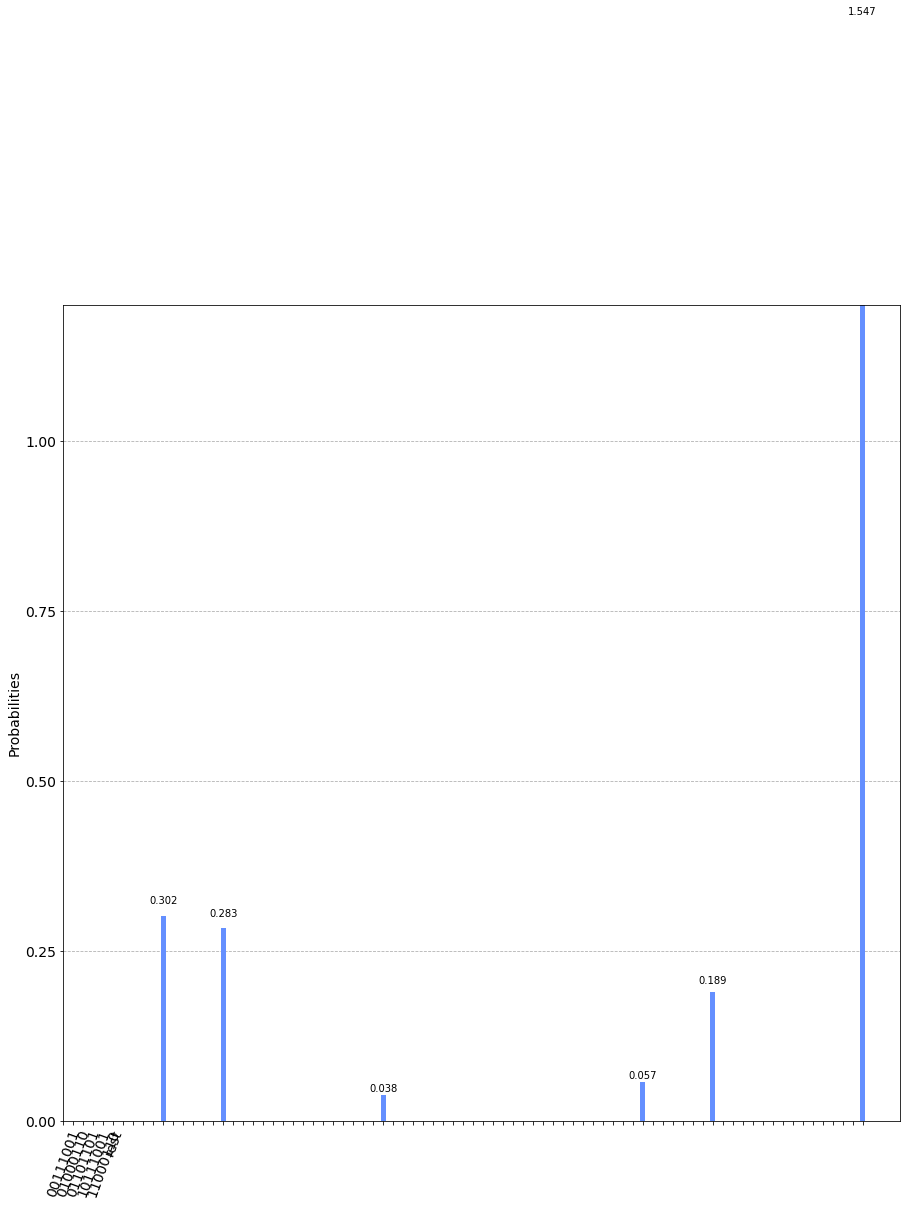

In [44]:
# Simulate plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend=qasm_simulator, shots=128).result()
plot_histogram(result.get_counts(), figsize=(15,15), sort='asc', number_to_keep=5, ax=None)